In [1]:
using Plots

In [2]:
# Update Vnew (in place)
function update_V!(V,Vnew,g,A,Z,Zmat,r,w,beta,delta)
    for ia in 1:size(V)[1]
        for iz in 1:size(V)[2]
            # TODO: Write the Bellman operator (Hint: use findmax)
            Vnew[ia,iz], g[ia,iz] = findmax(log.(max.((1+r-delta).*A[ia] .+ w.*Z[iz] .- A,0)) .+ beta .* V*Zmat[iz,:])
        end
    end
end

# Update Vnew until converged
function update_V(V,Vnew,g,A,Z,Zmat,r,w,beta,delta, maxiter = 1000, tol = 1e-5)
    it = 0
    V_diff = Inf
    while it < maxiter && V_diff > tol
        it += 1
        update_V!(V,Vnew,g,A,Z,Zmat,r,w,beta,delta)
        V_diff = maximum(abs.(Vnew .- V))
        V .= Vnew
    end
    if it == maxiter
        println("update_V did not converge")
    end
end

update_V (generic function with 3 methods)

In [3]:
# Update distribution over states given decision rule g
function state_dist_update!(g, state_dist,state_distnew, Zmat)
    state_distnew .= zeros(size(state_dist)[1], size(state_dist)[2])
    for i in 1:size(g)[1]
        for j in 1:size(g)[2]
            for k in 1:size(g)[2]
                # TODO: Update distribution
                state_distnew[Int(g[i,j]),k] += state_dist[i,j]*Zmat[j,k]
            end
        end
    end
    state_distnew ./= sum(state_distnew)
end

# Update distribution until converged
function state_dist_update(g, state_dist,state_distnew, Zmat, maxiter = 1000, tol = 1e-3)
    it = 0
    dist_diff = Inf
    while it < maxiter && dist_diff > tol
        it += 1
        state_dist_update!(g, state_dist,state_distnew, Zmat)
        dist_diff = maximum(abs.(state_distnew .- state_dist))
        state_dist .= state_distnew
    end
    if it == maxiter
        println("dist not converged")
    end
end


# Find capital supply given stationary distribution of states
function agg_K(state_dist, A)
    # TODO
    return (sum(state_dist,dims = 2)' * A)[1]
end

# Find labor supply given stationary distribution of states
function agg_N(state_dist,Z)
    # TODO
    return (sum(state_dist,dims=1) * Z)[1]
end

# Rental rate implied by firm problem
function rental(K,N,alpha)
    # TODO
    return alpha *(K/N)^(alpha-1)
end

# Wage rate implied by firm problem
function wage(K,N,alpha)
    # TODO
    return (1-alpha)*(K/N)^(alpha)
end

# Firm demand for capital, given price (and N)
function demand_K(r, N, alpha)
    # TODO
    return (r/alpha)^(1/(alpha-1))*N
end

# Find stationary distribution of Q process
function find_stat(Q, maxit = 100, pi_tol = 1e-6)
    pi = ones(size(Q)[1])
    pi ./= sum(pi)
    
    it = 0
    pi_diff = Inf
    while it < maxit && pi_diff > pi_tol
        it += 1
        pinew = Q' * pi
        pi_diff = sum(abs.(pinew .- pi))
        pi .= pinew
    end
    
    if it == maxit
        printn("find_stat not converged")
    end
    
    return pi
end

find_stat (generic function with 3 methods)

In [4]:
# Capital suppled by HHs given prices
function supply_K(r, w, A, Z, Zmat, 
        alpha, beta, delta,
        maxiter_hh = 1000, hh_tol = 1e-4,
        maxiter_dist = 1000, dist_tol = 1e-4,
    )
    
    # Initialize value function
    V = zeros(length(A),length(Z))
    Vnew = zeros(length(A),length(Z))
    
    # Initialize policy
    g = ones(length(A), length(Z))
    
    # Initialize distribution
    state_dist = ones(length(A), length(Z))
    state_dist ./= sum(state_dist)
    state_distnew = ones(length(A), length(Z))
    state_distnew ./= sum(state_distnew)
    
    # Find policies
    update_V(V,Vnew,g,A,Z,Zmat,r,w,beta,delta, maxiter_hh, hh_tol)
    
    # Find implied distribution
    state_dist_update(g, state_dist,state_distnew, Zmat, maxiter_dist, dist_tol)

    # Find aggregates
    K = agg_K(state_dist, A)
    N = agg_N(state_dist,Z)
    
    return [V, g, state_dist, K, N]
end

supply_K (generic function with 5 methods)

In [5]:
# Plot the HH capital supply and firm capital demand
# for rental prices rs
function plot_supply_demand(rs, A, Z, Zmat, 
        alpha, beta, delta,
        K = 10, N = 2,
        maxiter_hh = 100, hh_tol = 1e-6,
        maxiter_dist = 100, dist_tol = 1e-6,
    )
    
    # Initialize schedules
    Kd = zeros(length(rs))
    Ks = zeros(length(rs))
    
    # Find (exogenous) aggregate labor
    Zstat = find_stat(Zmat)
    N = Zstat' * Z
    for ir in 1:length(rs)
        r = rs[ir]
        Kd[ir] = demand_K(r,N,alpha)
        
        # Wage implied by capital demand and exogenous labor
        w = wage(Kd[ir],N,alpha)
        
        # Capital supplied by HHs
        Ks[ir] = supply_K(r, w, A, Z, Zmat, alpha, beta, delta)[4]
    end
    
    # Plot'em
    p = plot(Kd, rs, title = "Our Fig II (kinda)", label = "K(r)", 
        xlabel = "K", ylabel = "r")
    plot!(Ks,rs, label = "E[a]")
    display(p)
end

plot_supply_demand (generic function with 7 methods)

In [6]:
# Find steady state
function steady_state(A, Z, Zmat, 
        alpha, beta, delta,
        K = 10, N = 2,
        maxiter_hh = 1000, hh_tol = 1e-6,
        maxiter_agg = 300, agg_tol = 1e-3,
        maxiter_dist = 100, dist_tol = 1e-6,
        step_K = 0.5, step_N = 0.5
    )
    
    # Don't let r be above the rate of time discounting
    r = min(rental(K,N,alpha), 1/beta-1)
    w = wage(K,N,alpha)
    
    # Initialize
    V = zeros(length(A),length(Z))
    Vnew = zeros(length(A),length(Z))
    g = ones(length(A), length(Z))
    
    state_dist = ones(length(A), length(Z))
    state_dist ./= sum(state_dist)
    state_distnew = ones(length(A), length(Z))
    state_distnew ./= sum(state_distnew)
    
    iter_agg = 0
    agg_diff = Inf
    
    # Iterate until aggregates converge
    while iter_agg < maxiter_agg && agg_diff > agg_tol
        
        iter_agg += 1
        
        # Update prices
        r = rental(K,N,alpha)
        w = wage(K,N,alpha)
        
        # Find HH decision
        update_V(V,Vnew,g,A,Z,Zmat,r,w,beta,delta)
        
        # Find implied distribution
        state_dist_update(g, state_dist,state_distnew, Zmat)
        
        # Bisection method for updating
        Kold = K
        Knew = agg_K(state_dist, A)
        K = step_K * Knew .+ (1-step_K)*Kold
        
        Nold = N
        Nnew = agg_N(state_dist,Z)
        N = step_N * Nnew .+ (1-step_N)*Nold
        
        agg_diff = max(abs.(K .- Kold), abs.(N .- Nold))
        
    end
    return [V, g, state_dist, K, N, r, w]
end

steady_state (generic function with 11 methods)

First K: 3

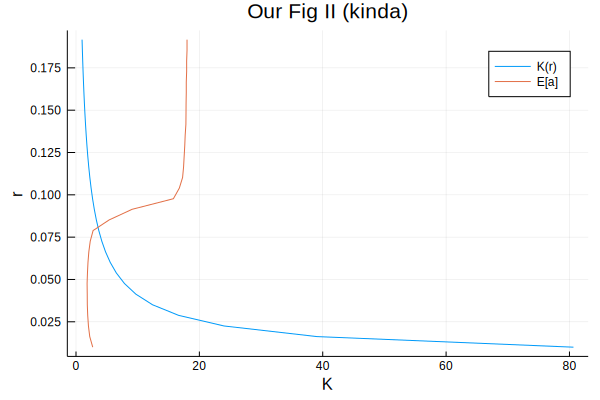

.3901579916021896
First N: 0.43669052124023444
First r: 0.08358382154935665


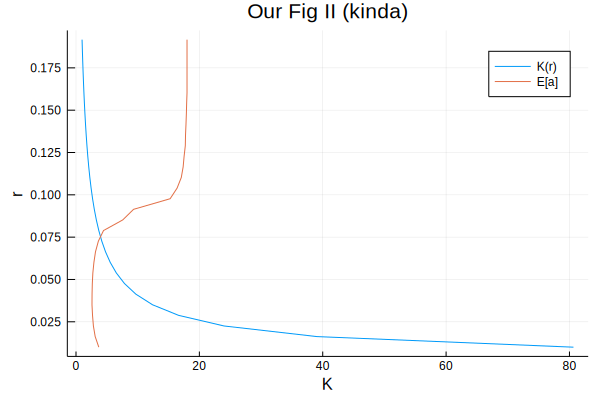

Second K: 3.858594379499513
Second N: 0.4366905212402344
Second r: 0.0766487399779501


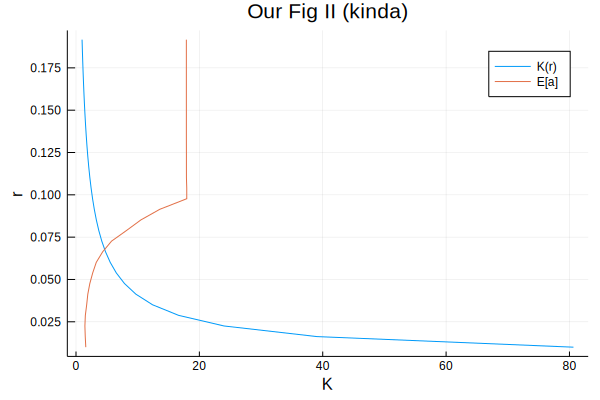

Third K: 4.609927922655665
Third N: 0.43676208496093744
Third r: 0.0680519714140373


In [7]:
# Parameters
alpha = 0.33
beta = 0.96
delta = 0.05
rs = collect(LinRange(0.01,1/beta - 1 + delta + 0.1,30))
A = collect(LinRange(0,1,100))
A *= 18
Z = [0.01, 0.3, 1.0]

# First
Zmat = [1/3 1/3 1/3; 1/3 1/3 1/3; 1/3 1/3 1/3]
s1 = steady_state(A, Z, Zmat, alpha, beta, delta)
println("First K: ", s1[4])
println("First N: ", s1[5])
println("First r: ", s1[6])
plot_supply_demand(rs, A, Z, Zmat, 
        alpha, beta, delta)

# Second
Zmat = [0.6 0.2 0.2; 0.2 0.6 0.2; 0.2 0.2 0.6]
s2 = steady_state(A, Z, Zmat, alpha, beta, delta)
println("Second K: ", s2[4])
println("Second N: ", s2[5])
println("Second r: ", s2[6])
plot_supply_demand(rs, A, Z, Zmat, 
        alpha, beta, delta)

# Third
Zmat = [0.98 0.01 0.01; 0.01 0.98 0.01; 0.01 0.01 0.98]
s3 = steady_state(A, Z, Zmat, alpha, beta, delta)
println("Third K: ", s3[4])
println("Third N: ", s3[5])
println("Third r: ", s3[6])
plot_supply_demand(rs, A, Z, Zmat, 
        alpha, beta, delta)